## Text Classification with Bidirectional Long Short Term Memory 

The core of our model is a multi-layered architecture, starting with an Embedding layer. This layer is configured to handle a vocabulary of up to 10,000 words and maps each word to a 64-dimensional vector space, allowing for a richer representation of text data. The input length is set to 100, ensuring uniformity in the input sequences.

Following the Embedding layer, the model introduces two Bidirectional LSTM (Long Short-Term Memory) layers. The first LSTM layer has 64 units and returns sequences, meaning it passes its outputs to the next LSTM layer. This bidirectional approach allows the model to capture dependencies in the text data from both past and future contexts, enhancing its understanding of language patterns.

The second LSTM layer consists of 32 units and does not return sequences, thus preparing the model to transition to the output layers.

Next, there is a Dense layer with 64 units and a 'relu' activation function. This layer serves as a fully connected neural network, introducing non-linearity to the model, which allows it to learn more complex patterns in the data.

Finally, the model concludes with a Dense output layer with a single unit and a 'sigmoid' activation function. This layer is responsible for producing the final classification output, determining the category of the input text.

#### Hemant Thapa

##### Importing Libraries 

In [1]:
import io
import json
import requests
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

##### Loading Json dataset 

In [3]:
def load_json_dataset(url):
    response = requests.get(url)
    
    if response.status_code == 200:
        datastore = json.loads(response.text)
    
        sentences = []
        labels = []
    
        for item in datastore:
            sentences.append(item['headline'])
            labels.append(item['is_sarcastic'])
        
        return datastore, sentences, labels
    else:
        print(f"Failed to fetch data from URL. Status code: {response.status_code}")
        return None, None, None

In [4]:
datastore, sentences, labels = load_json_dataset("https://storage.googleapis.com/learning-datasets/sarcasm.json")

In [5]:
datastore[:5]

[{'article_link': 'https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5',
  'headline': "former versace store clerk sues over secret 'black code' for minority shoppers",
  'is_sarcastic': 0},
 {'article_link': 'https://www.huffingtonpost.com/entry/roseanne-revival-review_us_5ab3a497e4b054d118e04365',
  'headline': "the 'roseanne' revival catches up to our thorny political mood, for better and worse",
  'is_sarcastic': 0},
 {'article_link': 'https://local.theonion.com/mom-starting-to-fear-son-s-web-series-closest-thing-she-1819576697',
  'headline': "mom starting to fear son's web series closest thing she will have to grandchild",
  'is_sarcastic': 1},
 {'article_link': 'https://politics.theonion.com/boehner-just-wants-wife-to-listen-not-come-up-with-alt-1819574302',
  'headline': 'boehner just wants wife to listen, not come up with alternative debt-reduction ideas',
  'is_sarcastic': 1},
 {'article_link': 'https://www.huffingtonpost.com/entry/jk-rowling-w

In [6]:
sentences[:5]

["former versace store clerk sues over secret 'black code' for minority shoppers",
 "the 'roseanne' revival catches up to our thorny political mood, for better and worse",
 "mom starting to fear son's web series closest thing she will have to grandchild",
 'boehner just wants wife to listen, not come up with alternative debt-reduction ideas',
 'j.k. rowling wishes snape happy birthday in the most magical way']

In [7]:
labels[:10]

[0, 0, 1, 1, 0, 0, 0, 0, 1, 0]

##### Exporting Json file to text format 

In [8]:
if datastore:
    print(f"Loaded {len(sentences)} sentences and {len(labels)} labels.")
    #save datastore to a text file
    with open("datastore.txt", "w") as outfile:
        json.dump(datastore, outfile)
else:
    print("Data loading failed.")

Loaded 26709 sentences and 26709 labels.


##### Feature Engineering - Train and Test Size 

In [9]:
training_size = 20000

In [10]:
print(f"Training size of data : {training_size}")
print(f"Testing size of data : {len(sentences) - training_size}")

Training size of data : 20000
Testing size of data : 6709


In [11]:
training_sentences = sentences[0:training_size]
training_labels = labels[0:training_size]

In [12]:
testing_sentences = sentences[training_size:]
testing_labels = labels[training_size:]

In [13]:
#an object of tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")

In [14]:
#fitting model
tokenizer.fit_on_texts(training_sentences)

In [15]:
#word index
word_index = tokenizer.word_index

In [16]:
#text to sequences 
training_sequences = tokenizer.texts_to_sequences(training_sentences)
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)

In [17]:
#padding 
training_padded = pad_sequences(training_sequences, maxlen=100, padding='post', truncating='post')
testing_padded = pad_sequences(testing_sequences, maxlen=100, padding='post', truncating='post')

In [18]:
#comverting to numpy array
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

##### Selecting Model 

In [19]:
model = tf.keras.Sequential([
    #embedding layer with an embedding dimension of 64
    tf.keras.layers.Embedding(10000, 64, input_length=100),  
    #first Bidirectional LSTM layer with 64 units
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),  
    #second Bidirectional LSTM layer with 32 units
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),  
    #modified second-to-last dense layer with 64 units
    tf.keras.layers.Dense(64, activation='relu'),  
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 64)           640000    
                                                                 
 bidirectional (Bidirection  (None, 100, 128)          66048     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 751489 (2.87 MB)
Trainable params: 751489 

In [21]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
num_epochs = 50
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/50
625/625 - 62s - loss: 0.3825 - accuracy: 0.8195 - val_loss: 0.3419 - val_accuracy: 0.8472 - 62s/epoch - 99ms/step
Epoch 2/50
625/625 - 50s - loss: 0.1876 - accuracy: 0.9248 - val_loss: 0.3633 - val_accuracy: 0.8535 - 50s/epoch - 79ms/step
Epoch 3/50
625/625 - 50s - loss: 0.1046 - accuracy: 0.9614 - val_loss: 0.4167 - val_accuracy: 0.8487 - 50s/epoch - 80ms/step
Epoch 4/50
625/625 - 41s - loss: 0.0592 - accuracy: 0.9787 - val_loss: 0.5074 - val_accuracy: 0.8450 - 41s/epoch - 65ms/step
Epoch 5/50
625/625 - 40s - loss: 0.0427 - accuracy: 0.9848 - val_loss: 0.5903 - val_accuracy: 0.8386 - 40s/epoch - 63ms/step
Epoch 6/50
625/625 - 42s - loss: 0.0267 - accuracy: 0.9908 - val_loss: 0.7953 - val_accuracy: 0.8365 - 42s/epoch - 67ms/step
Epoch 7/50
625/625 - 43s - loss: 0.0165 - accuracy: 0.9944 - val_loss: 0.9445 - val_accuracy: 0.8301 - 43s/epoch - 69ms/step
Epoch 8/50
625/625 - 45s - loss: 0.0127 - accuracy: 0.9960 - val_loss: 0.8886 - val_accuracy: 0.8351 - 45s/epoch - 72ms/step


##### Loss and Accuracy plot 

In [23]:
def plot_graphs(history, string, title=None, xlabel="Epochs", ylabel=None):
    plt.figure(figsize=(6, 5))
    epochs = range(1, len(history.history[string]) + 1)
    train_values = history.history[string]
    val_values = history.history['val_' + string]

    plt.plot(epochs, train_values, linestyle='-', color='blue', label='Training ' + string)
    plt.plot(epochs, val_values, linestyle='-', color='green', label='Validation ' + string)

    if title:
        plt.title(title)
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)

    plt.legend()
    plt.grid(True, linestyle='--', color='black', alpha=0.2)
    plt.show()

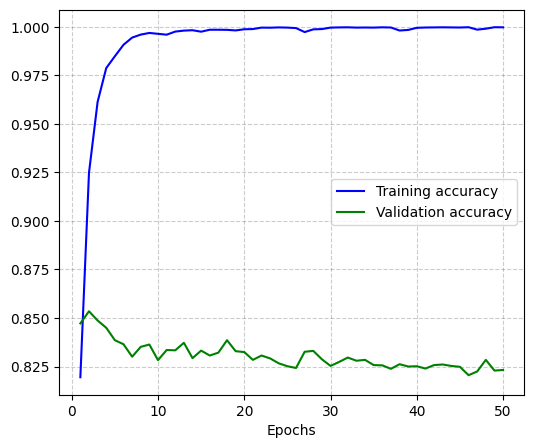

In [24]:
plot_graphs(history, "accuracy")

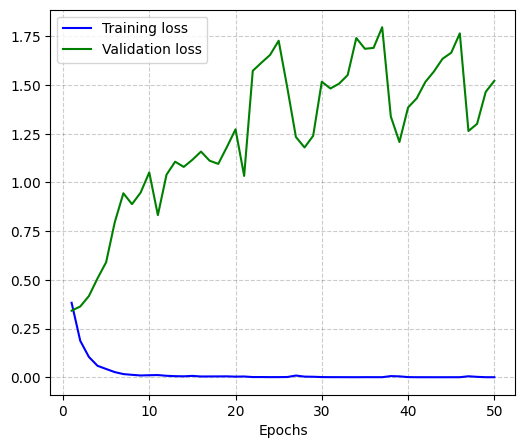

In [25]:
plot_graphs(history, "loss")

In [26]:
#inversing word index
reverse_word_index = {}
for key, value in word_index.items():
    reverse_word_index[value] = key

In [27]:
#decoding sentence
def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [28]:
print(decode_sentence(training_padded[0]))

former <OOV> store clerk sues over secret 'black <OOV> for minority shoppers ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?


In [29]:
print(training_sentences[2])

mom starting to fear son's web series closest thing she will have to grandchild


In [30]:
print(labels[2])

1


In [31]:
#vocab_size, embedding_dim
e = model.layers[0]
weights = e.get_weights()[0]

In [32]:
print(weights.shape) 

(10000, 64)


In [33]:
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, 10000):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [34]:
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]

In [35]:
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')

In [36]:
predictions = model.predict(padded)

1/1 [==============================] - 2s 2s/step


In [37]:
np.set_printoptions(suppress=True)

In [38]:
print(predictions)

[[0.04419415]
 [0.00002396]]


Close to 1 : High probability of sarcasm

Close to 0 : Low probability of sarcasm 

In [39]:
def text_classification_test(string):
    temp_sequences = tokenizer.texts_to_sequences([string])
    temp_padded = pad_sequences(temp_sequences, maxlen=100, padding='post', truncating='post')
    temp_predictions = model.predict(temp_padded)
    #model returns a single prediction value
    sentiment_score = temp_predictions[0]  
    classification = ""

    if sentiment_score < -0.4:
        classification = "Very Bad"
    elif sentiment_score < 0:
        classification = "Bad"
    elif sentiment_score < 0.5:
        classification = "Not Bad"
    else:
        classification = "Good"

    print(f"Text: {string}")
    print(f"Sentiment Score: {sentiment_score}")
    print(f"Classification: {classification}")

In [40]:
text_classification_test("Oh, great! Another Monday to look forward to")

1/1 [==============================] - 0s 37ms/step
Text: Oh, great! Another Monday to look forward to
Sentiment Score: [0.86780095]
Classification: Good


In [41]:
text_classification_test("Wow, my day couldn't get any better! Another flat tire on my way to work in this pouring rain.")

1/1 [==============================] - 0s 31ms/step
Text: Wow, my day couldn't get any better! Another flat tire on my way to work in this pouring rain.
Sentiment Score: [0.00000006]
Classification: Not Bad


In [42]:
text_classification_test("I'm absolutely thrilled to be stuck in traffic for hours on a Friday evening.")

1/1 [==============================] - 0s 33ms/step
Text: I'm absolutely thrilled to be stuck in traffic for hours on a Friday evening.
Sentiment Score: [0.99999696]
Classification: Good


In [43]:
text_classification_test("I just won the lottery, and now I have to pay taxes on it! Life is so unfair.")

1/1 [==============================] - 0s 25ms/step
Text: I just won the lottery, and now I have to pay taxes on it! Life is so unfair.
Sentiment Score: [0.00000025]
Classification: Not Bad


**References:**

**Book:**

- *Sculpting Data for ML: The First Act of Machine Learning*
  - Authors: Jigyasa Grover, Rishabh Misra
  - Publisher: Jigyasa Grover & Rishabh Misra
  - Year: 2021
  - ISBN: 9798585463570
  - Page Count: 158
  - Language: English
  - Contributors: Julian McAuley, Laurence Moroney, Mengting Wan
ting Wan
